In [7]:
#Setting up the connection

In [200]:
from breeze_connect import BreezeConnect
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [45]:
breeze = BreezeConnect(api_key = 'ge528J31807C23m1138209727YT28K7*')

In [46]:
import urllib
print("https://api.icicidirect.com/apiuser/login?api_key="+urllib.parse.quote_plus("ge528J31807C23m1138209727YT28K7*"))


https://api.icicidirect.com/apiuser/login?api_key=ge528J31807C23m1138209727YT28K7%2A


In [47]:
breeze.generate_session(api_secret="7$`4002714a8v&50&014906179j^4881",
                        session_token="11233063")

{'Success': None, 'Status': 500, 'Error': 'Invalid User Details'}

In [180]:
dict = breeze.get_historical_data_v2(interval="1day",
                            from_date= "2023-04-01T07:00:00.000Z",
                            to_date= "2023-04-25T07:00:00.000Z",
                            stock_code="NIFTY",
                            exchange_code="NSE")

In [181]:
dict

{'Error': None,
 'Status': 200,
 'Success': [{'close': 17399.7,
   'datetime': '2023-04-03 00:00:00',
   'exchange_code': 'NSE',
   'high': 17427.95,
   'low': 17312.9,
   'open': 17427.95,
   'stock_code': 'NIFTY',
   'volume': 0},
  {'close': 17561.0,
   'datetime': '2023-04-05 00:00:00',
   'exchange_code': 'NSE',
   'high': 17570.0,
   'low': 17412.15,
   'open': 17422.3,
   'stock_code': 'NIFTY',
   'volume': 0},
  {'close': 17602.0,
   'datetime': '2023-04-06 00:00:00',
   'exchange_code': 'NSE',
   'high': 17637.7,
   'low': 17503.6,
   'open': 17533.85,
   'stock_code': 'NIFTY',
   'volume': 0},
  {'close': 17613.05,
   'datetime': '2023-04-10 00:00:00',
   'exchange_code': 'NSE',
   'high': 17693.3,
   'low': 17598.25,
   'open': 17634.9,
   'stock_code': 'NIFTY',
   'volume': 0},
  {'close': 17722.25,
   'datetime': '2023-04-11 00:00:00',
   'exchange_code': 'NSE',
   'high': 17748.6,
   'low': 17655.3,
   'open': 17704.8,
   'stock_code': 'NIFTY',
   'volume': 0},
  {'close'

In [112]:
dict['Success'][3]['datetime'][:10]

'2023-04-10'

In [50]:
d=[{'date': x['datetime'][:10], 'close': x['close']} for x in dict['Success']]

In [66]:
pd.DataFrame([[x['datetime'][:10], x['close']] for x in dict['Success']], columns = ['Date', 'Close']).set_index('Date')

,Close
Date,
2013-04-01,204.8
2013-04-02,204.77
2013-04-03,205.07
2013-04-04,199.7
2013-04-05,194.2
...,...
2023-03-24,378.7
2023-03-27,380.2
2023-03-28,379.75


In [198]:
#Constants

In [199]:
RF = 3
TIMEDELTA = 365

In [8]:
#Portfolio

In [193]:

def get_cov_mat(stocks, from_date="2013-04-01T07:00:00.000Z", to_date="2023-03-31T07:00:00.000Z"):
    data_dict = {}    
    for stock in stocks:
        dict = breeze.get_historical_data(interval="1day", from_date=from_date, to_date=to_date, stock_code=stock, exchange_code="NSE", product_type="cash")
        #data_dict[stock]=[{'date': x['datetime'][:10], 'close': x['close']} for x in dict['Success']]
        data_dict[stock] = pd.DataFrame([[x['datetime'][:10], float(x['close'])] for x in dict['Success']], columns = ['Date', stock]).set_index('Date')
    
    data = []
    for key in data_dict:
        data.append(data_dict[key])

    price_data = pd.concat(data, axis=1, join='inner')
    
    index_data = price_data[['NIFTY']]
    price_data = price_data.drop(['NIFTY'], axis=1)

    log_ret = np.log(price_data/price_data.shift(1))

    cov_mat = log_ret.cov()
    cov_mat = cov_mat*252  #assuming 252 trading days in a year
    ret = (log_ret.mean()+1)**252-1

    return price_data, index_data, cov_mat, ret

In [202]:
def amt_to_wt(amounts):
    total=sum(amounts)
    return np.array([a/total for a in amounts])

In [169]:
tickermatch = pd.read_csv('NSEScripMaster.csv', index_col='ExchangeCode').to_dict()['ShortName']

In [208]:
price_data, index_data, cov_mat, ret = get_cov_mat([tickermatch['HDFCBANK'], tickermatch['ITC'], 'NIFTY'])

In [196]:
print(price_data.head())
print(index_data.head())
print(cov_mat)
print(ret)

            HDFBAN     ITC
Date                      
2013-04-01  311.93  204.80
2013-04-02  314.95  204.77
2013-04-03  311.83  205.07
2013-04-04  308.08  199.70
2013-04-05  310.48  194.20
              NIFTY
Date               
2013-04-01  5704.40
2013-04-02  5748.10
2013-04-03  5672.90
2013-04-04  5574.75
2013-04-05  5553.25
          HDFBAN       ITC
HDFBAN  0.056462  0.019466
ITC     0.019466  0.068517
HDFBAN    0.183145
ITC       0.066417
dtype: float64


In [201]:
class Portfolio(object):
    def __init__(self, secs, weights):

        self.secs = secs
        self.weights = weights

        self.pdata, self.idata, cov_mat, returns  = get_cov_mat(self.secs)

        self.ret = round(np.dot(returns, self.weights)*100, 2)
        self.std = round(np.sqrt(np.dot(self.weights.T, np.dot(cov_mat, self.weights.T)))*100, 2)
        self.sharpe = round((self.ret-RF)/self.std,2)

    def __str__(self):
        return f"Returns: {self.ret}% Std: {self.std}%"

    def plot_performance(self):
        index = 100
        ind_val=[index]
        day = self.weights*100
        port_val = []
        port_val.append(day.sum())

        piret = self.pdata/self.pdata.shift(1)
        inret = self.idata/self.idata.shift(1)

        for i in range(1, len(piret)):
            day = np.array(day*piret.iloc[i])
            port_val.append(day.sum())
            index = index*inret.iloc[i][0]
            ind_val.append(index)
        
        self.pdata['port_val'] = port_val
        self.pdata['ind_val'] = ind_val
        
        index_return = ((np.log(self.idata/self.idata.shift(1)).mean()+1)**252-1)[0]
        std_return_diff = np.std(self.pdata['port_val']/self.pdata['port_val'].shift(1)-self.pdata['ind_val']/self.pdata['ind_val'].shift(1))
        self.inf = (self.ret/100-index_return)/std_return_diff

        plt.plot(self.pdata['port_val'], label="Portfolio")
        plt.plot(self.pdata['ind_val'], label="Nifty")
        sns.lineplot(self.pdata['port_val'])
        #plt.savefig('media\plot.png')


In [204]:
def compute_portfolio(ticks, amounts):
    if len(ticks) == 0:
        return 0, 0
    secs = [tickermatch[tick] for tick in ticks]
    port = Portfolio(secs, amt_to_wt(amounts))
    port.plot_performance()
    


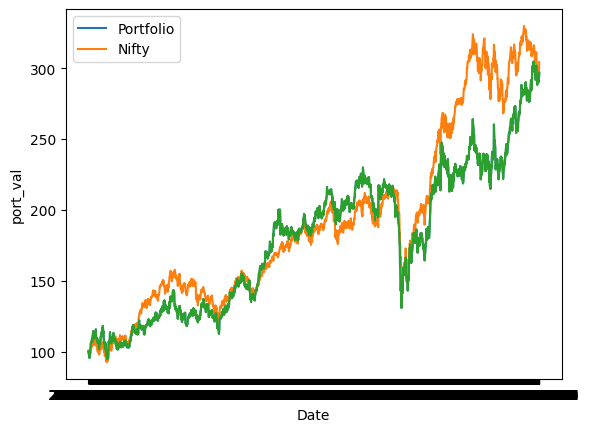

In [207]:
compute_portfolio(['ITC', 'HDFCBANK', 'NIFTY 50'], [200, 100])